In [1]:
import h5py
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools 
import pyts
from pyts.approximation import PiecewiseAggregateApproximation

from sklearn.utils import class_weight

import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Convolution2D,Conv2D, Dense,Dropout, Flatten, Activation, MaxPooling2D, Input, Conv1D, GlobalAveragePooling1D, TimeDistributed, GRU, LSTM

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')

try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

2022-02-13 10:52:13.201850: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0


2.5.0
Num GPUs Available:  1


2022-02-13 10:52:14.571462: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcuda.so.1
2022-02-13 10:52:14.613874: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-13 10:52:14.613953: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-13 10:52:14.627615: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-13 10:52:14.627677: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11
2022-02-13 10:52:14.634402: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library li

In [2]:
from os import environ
dataset = environ['dataset']
print(dataset)

refit_gen_GASF_13m_100S5X_15A166006_R42-80-20


In [3]:
#my defs 
from modules.models import  LSTM_3D_V56, CNN_V56,LSTM_BI_V56
from modules.tools import my_print, plot_confusion_matrix_norm, get_data,get_data_split, evaluate_model, create_tl_model
from modules.HDF5ImageGenerator import HDF5ImageGenerator

In [4]:
#LOAD DATASET
#file_name = "ukdale_gen_GASF_13m_100S5X12A54480"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006"
file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42-80-20"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42_80-20"
file_name = "refit_gen_GASF_60m_300S0X_15A157030N_R12_80-20-V1"
file_name = environ["dataset"]
#read the file
path = str(pathlib.Path().resolve())

path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"

file = h5py.File(path_data,"r+")

In [5]:
x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)

['HEKA', 'fridge/freezer', 'audio system', 'breadmaker', 'broadband router', 'computer', 'dehumidifier', 'dish washer', 'electric space heater', 'food processor', 'pond pump', 'television', 'tumble dryer', 'washer dryer', 'washing machine']
{0: 0.3663356504468719, 1: 0.22525951557093427, 2: 6.4672023374726075, 3: 34.85669291338583, 4: 4.910482529118137, 5: 0.43032954214056574, 6: 18.068571428571428, 7: 2.8259176508139165, 8: 11.852208835341365, 9: 12.611965811965812, 10: 2.7789077212806026, 11: 0.2799203262828417, 12: 7.359600997506234, 13: 38.32727272727273, 14: 2.2073298429319372}
 
Tests 
HEKA test: 6042 train: 24168
fridge/freezer test: 9826 train: 39304
audio system test: 342 train: 1369
breadmaker test: 64 train: 254
broadband router test: 451 train: 1803
computer test: 5143 train: 20574
dehumidifier test: 123 train: 490
dish washer test: 783 train: 3133
electric space heater test: 187 train: 747
food processor test: 175 train: 702
pond pump test: 796 train: 3186
television test:

In [6]:
def select_model(learn_type):
    
    if learn_type == "CNN":
        model = CNN_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "LSTM":
        model = LSTM_3D_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "BI_LSTM":
        model = LSTM_BI_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    return model
              

In [7]:
path_save = path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']
path_save_nb = path_save+"_out.ipynb"
path_save_log = path_save+"_out_log2.txt"

In [8]:
from keras.callbacks import LambdaCallback
#path_log= path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']+"_log.txt"
txt_log = open(path_save+"_log.txt", mode='wt', buffering=1)
txt_log.write("file created! \n")

save_op_callback = LambdaCallback(
  on_epoch_end = lambda epoch, logs: txt_log.write(
    str({'epoch': epoch, 'loss': logs['loss'],'acc': logs['accuracy']}) + '\n'),
                                                           
)

In [9]:
print(path_save_nb)

/workspace/notebooks/experiment_automation/output/BI_LSTM/refit/TL/refit_42_iawe_out.ipynb


In [10]:
# rm $path_save_log

In [11]:
# %%capture cap 

# with open(path_save_log,"wt") as f:
#     f.write(cap.stdout)
    
# print("out capture..")

In [12]:
# %%capture cap --no-stderr


if environ['train_type'] == "BB":

    #define generator
    train_gen = HDF5ImageGenerator(
        src= path_data,
        X_key="data/train/gaf",
        y_key="labels/train/gaf",
        classes_key="appliances/classes",
        labels_encoding="hot",
        shuffle=True,
        batch_size=int(environ['batch_size']),
        num_classes=num_of_classes,
        mode="train",
        )
    
    model = select_model(environ['learn_type'])
    
    txt_log.write("fitting BB model: \n")
    
    model.fit(
        train_gen,
        verbose=2,
        epochs=int(environ['epochs']),
        class_weight=d_class_weights,
        callbacks = [save_op_callback],
    )
    
    txt_log.write("finished fitting BB model: \n")

    evaluate_model(model,x_test,y_test,appliances)
    
    if environ['save_model']=="True":

        path_model_save = path+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]
        model.save(path_model_save)
        txt_log.write("model saved to:"+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]+" \n")
        
        
# with open(path_save+"_out_log.txt" as f:
#     f.write(cap.stdout)


In [13]:
#model = keras.models.load_model(path_model1)
# model_used = model

In [14]:
# evaluate_model(model,x_test,y_test,appliances)

using dataset data refit training on model iawe seed 42
reading data, printing stats: 
['HEKA', 'fridge/freezer', 'audio system', 'breadmaker', 'broadband router', 'computer', 'dehumidifier', 'dish washer', 'electric space heater', 'food processor', 'pond pump', 'television', 'tumble dryer', 'washer dryer', 'washing machine']
{0: 0.3663356504468719, 1: 0.22525951557093427, 2: 6.4672023374726075, 3: 34.85669291338583, 4: 4.910482529118137, 5: 0.43032954214056574, 6: 18.068571428571428, 7: 2.8259176508139165, 8: 11.852208835341365, 9: 12.611965811965812, 10: 2.7789077212806026, 11: 0.2799203262828417, 12: 7.359600997506234, 13: 38.32727272727273, 14: 2.2073298429319372}
 
Tests 
HEKA test: 6042 train: 24168
fridge/freezer test: 9826 train: 39304
audio system test: 342 train: 1369
breadmaker test: 64 train: 254
broadband router test: 451 train: 1803
computer test: 5143 train: 20574
dehumidifier test: 123 train: 490
dish washer test: 783 train: 3133
electric space heater test: 187 train: 7

2022-02-13 10:52:33.634866: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-13 10:52:33.636495: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1872] Adding visible gpu devices: 0
2022-02-13 10:52:33.639112: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-13 10:52:34.524713: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-02-13 10:52:34.524775: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2022-02-13 10:52:34.525017: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2022-02-13 10:52:34.526221: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1418] Created TensorFlow device 

Normal way
[0 1 2 3 4 5 6 7 8 9]
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2022-02-13 10:52:42.385992: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-13 10:52:42.408720: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3299990000 Hz


Epoch 1/50


2022-02-13 10:52:45.886295: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudnn.so.8
2022-02-13 10:52:46.632301: I tensorflow/stream_executor/cuda/cuda_dnn.cc:380] Loaded cuDNN version 8202
2022-02-13 10:52:47.511914: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-13 10:52:48.284329: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11


4151/4151 - 87s - loss: 1.5042 - accuracy: 0.4758
Epoch 2/50
4151/4151 - 123s - loss: 1.2854 - accuracy: 0.5121
Epoch 3/50
4151/4151 - 118s - loss: 1.2319 - accuracy: 0.5284
Epoch 4/50
4151/4151 - 118s - loss: 1.2104 - accuracy: 0.5360
Epoch 5/50
4151/4151 - 117s - loss: 1.1805 - accuracy: 0.5404
Epoch 6/50
4151/4151 - 120s - loss: 1.1681 - accuracy: 0.5489
Epoch 7/50
4151/4151 - 117s - loss: 1.1541 - accuracy: 0.5543
Epoch 8/50
4151/4151 - 118s - loss: 1.1404 - accuracy: 0.5596
Epoch 9/50
4151/4151 - 116s - loss: 1.1426 - accuracy: 0.5574
Epoch 10/50
4151/4151 - 118s - loss: 1.1335 - accuracy: 0.5602
Epoch 11/50
4151/4151 - 117s - loss: 1.1168 - accuracy: 0.5601
Epoch 12/50
4151/4151 - 117s - loss: 1.1253 - accuracy: 0.5557
Epoch 13/50
4151/4151 - 115s - loss: 1.1164 - accuracy: 0.5592
Epoch 14/50
4151/4151 - 115s - loss: 1.1177 - accuracy: 0.5595
Epoch 15/50
4151/4151 - 114s - loss: 1.1100 - accuracy: 0.5641
Epoch 16/50
4151/4151 - 112s - loss: 1.1022 - accuracy: 0.5642
Epoch 17/50
4

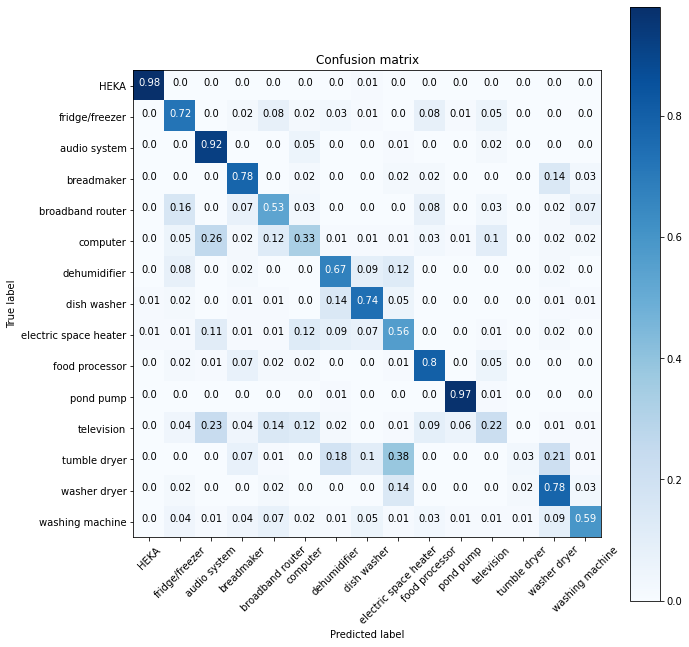

In [15]:
# datasets =[
#     "ukdale_gen_GASF_13m_100S5X12A54480_R82_80-20"
# ]

if environ['train_type'] == "TL": 
    models = environ['tl_datasets'].replace(" ","").split(",")
    #model = ["base"]
    
    for model in models:
    
        file_name = dataset
        
        datasetTL = model
        
        seed = dataset.split("_R")[1][0:2]
        
        print("using dataset data",dataset.split("_")[0],"training on model",model,"seed",environ['seed'])
        txt_log.write("starting "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        tf.keras.backend.clear_session()


        #read the file
        path = str(pathlib.Path().resolve())
        path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"
        file = h5py.File(path_data,"r+")


        print("reading data, printing stats: ")
        x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)
        print("loading model")
        
        model_seed = 42
        model_used = create_tl_model(model,environ['learn_type'],model_seed,path,num_of_classes)
                
        train_gen = HDF5ImageGenerator(
            src= path_data,
            X_key="data/train/gaf",
            y_key="labels/train/gaf",
            classes_key="appliances/classes",
            labels_encoding="hot",
            shuffle=True,
            batch_size=int(environ['batch_size']),
            num_classes=num_of_classes,
            mode="train",
            )

        model_used.fit(
            train_gen,
            verbose=2,
            epochs=int(environ['epochs']),
            class_weight=d_class_weights,
            callbacks = [save_op_callback]
            #workers = 6,
        )
        
        txt_log.write("finished "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        evaluate_model(model_used,x_test,y_test,appliances)
        



        #del model_used



In [16]:
txt_log.close()